In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import splitfolders
%matplotlib widget
import sys
sys.path.append('..')
from Modules import display as disp
import segmentation_models_3D as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

2022-08-16 12:41:54.184539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 12:41:54.184705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `tf.keras` framework.


In [ ]:
TRAINING_DATASET_PATH = "/user/lcorcos/home/Desktop/MRI_Project/Data_10_sample"
OUTPUT_NPY_DATASET = '/user/lcorcos/home/Desktop/MRI_Project/DataPy'

T1_list = sorted(glob.glob(f'{TRAINING_DATASET_PATH}/Best_Color/*/T1w/T1w_acpc_dc_restore.nii.gz'))
T2_list = sorted(glob.glob(f'{TRAINING_DATASET_PATH}/Best_Color/*/T1w/T2w_acpc_dc_restore.nii.gz'))
print(len(T1_list), len(T2_list))

Mask_list = sorted(glob.glob(f'{TRAINING_DATASET_PATH}/Masks/*/T1w/*'))
print(len(Mask_list))

In [ ]:
for img in range(len(T2_list)): 
    print("Now preparing image and masks number: ", img)
    zero_mat = np.zeros((256,9,256))
    
    temp_image_t1=nib.load(T1_list[img]).get_fdata()
    print("Before - temp_image_t1 shap = ", temp_image_t1.shape)
    temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
    temp_image_t1 = temp_image_t1[0:256, :, 2:258]
    temp_image_t1 = np.concatenate((temp_image_t1, zero_mat), axis=1)
    print("After - temp_image_t1 shap = ", temp_image_t1.shape, "\n")
    
    temp_image_t2=nib.load(T2_list[img]).get_fdata()
    print("Before - temp_image_t2 shap = ", temp_image_t2.shape)
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    temp_image_t2 = temp_image_t2[0:256, :, 2:258]
    temp_image_t2 = np.concatenate((temp_image_t2, zero_mat), axis=1)
    print("After - temp_image_t2 shap = ", temp_image_t2.shape, "\n")
    
    temp_mask=nib.load(Mask_list[img]).get_fdata()
    print("Before - temp_mask shap = ", temp_mask.shape)
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask = temp_mask[0:256, :, 2:258]
    temp_mask = np.concatenate((temp_mask, zero_mat), axis=1)
    temp_mask= to_categorical(temp_mask, num_classes=8)
    print("After - temp_mask shap = ", temp_mask.shape, "\n---------------------------")
    
    temp_combined_images = np.stack([temp_image_t1, temp_image_t2], axis=3)
    
    np.save(f'{OUTPUT_NPY_DATASET}/NII_Files/image_'+str(img)+'.npy', temp_combined_images)
    np.save(f'{OUTPUT_NPY_DATASET}/Masks/mask_'+str(img)+'.npy', temp_mask)

In [ ]:
# Verification of the saved files

my_img=np.load('/user/lcorcos/home/Desktop/MRI_Project/DataPy/NII_Files/image_0.npy')
print(my_img.shape)
my_mask=np.load('/user/lcorcos/home/Desktop/MRI_Project/DataPy/Masks/mask_0.npy')
print(my_mask.shape)

In [ ]:
# Creating dataset

input_folder = '/user/lcorcos/home/Desktop/MRI_Project/DataPy'
output_folder = '/user/lcorcos/home/Desktop/MRI_Project/Dataset'

# 70 % Train - 20 % Test - 10 % Validation 
splitfolders.ratio(input_folder, output=output_folder, seed=20, ratio=(0.7, 0.1, 0.2), group_prefix=None, move=True)

_____
#### DATA GENERATOR
____

In [2]:
import os
import numpy as np

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

_____
#### GENERATOR TEST
_____

In [3]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/NII_Files/"
train_mask_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/Masks/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

In [ ]:
print(train_img_list, train_mask_list)

In [4]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator
img, msk = train_img_datagen.__next__()

In [ ]:
print(img.shape, "---", msk.shape)

In [ ]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image T1')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image T2')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice], cmap='jet', interpolation=None)
plt.title('Mask')
plt.show()

In [ ]:
import sys

sys.path.append('..')
from Project.My_3D_Unet_model import simple_unet_model

In [ ]:
#Test if everything is working ok.
model = simple_unet_model(256, 320, 256, 2, 8)
print(model.input_shape)
print(model.output_shape)

In [ ]:
train_img_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/NII_Files/"
train_mask_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/Masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image T1')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image T2')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
import pandas as pd
columns = ['0','1', '2', '3', '4', '5', '6', '7', '8']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/Masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
label_4 = df['4'].sum()
label_5 = df['5'].sum()
label_6 = df['6'].sum()
label_7 = df['7'].sum()
label_8 = df['8'].sum()

total_labels = label_0 + label_1 + label_2 + label_3 + label_4 +label_5 + label_6 + label_7 + label_8
n_classes = 8
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)
wt4 = round((total_labels/(n_classes*label_4)), 2)
wt5 = round((total_labels/(n_classes*label_5)), 2)
wt6 = round((total_labels/(n_classes*label_6)), 2)
wt7 = round((total_labels/(n_classes*label_7)), 2)
wt8 = round((total_labels/(n_classes*label_8)), 2)

In [5]:
train_img_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/NII_Files/"
train_mask_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/train/Masks/"

val_img_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/test/NII_Files/"
val_mask_dir = "/user/lcorcos/home/Desktop/MRI_Project/Dataset/test/Masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [6]:
import keras

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [ ]:
batch_size = 2
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

print(steps_per_epoch, val_steps_per_epoch)

In [ ]:
model = simple_unet_model(IMG_HEIGHT=256, 
                          IMG_WIDTH=320, 
                          IMG_DEPTH=256, 
                          IMG_CHANNELS=2, 
                          num_classes=8)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

In [ ]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=2,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('3D_UNET_SEG.hdf5')

In [7]:
from keras.models import load_model

my_model = load_model('/user/lcorcos/home/Desktop/MRI_Project/mri-segmentation/Project/TF_segmentation/3D_UNET_SEG.hdf5', compile=False)

2022-08-16 12:42:38.502419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 12:42:38.502452: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 12:42:38.502472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eire): /proc/driver/nvidia/version does not exist
2022-08-16 12:42:38.502674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=1 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 29s 29s/step
Mean IoU = 0.17597112


In [20]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
test_img = np.load("/user/lcorcos/home/Desktop/MRI_Project/Dataset/val/NII_Files/image_1.npy")

test_mask = np.load("/user/lcorcos/home/Desktop/MRI_Project/Dataset/val/Masks/mask_1.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)
print(test_mask_argmax.shape)

test_img_input = np.expand_dims(test_img, axis=0)
print(test_img_input.shape)

(256, 320, 256)
(1, 256, 320, 256, 2)


In [21]:
test_prediction = my_model.predict(test_img_input)
print(test_prediction.shape)

1/1 [==============================] - 26s 26s/step
(1, 256, 320, 256, 8)


In [24]:
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

(256, 320, 256)


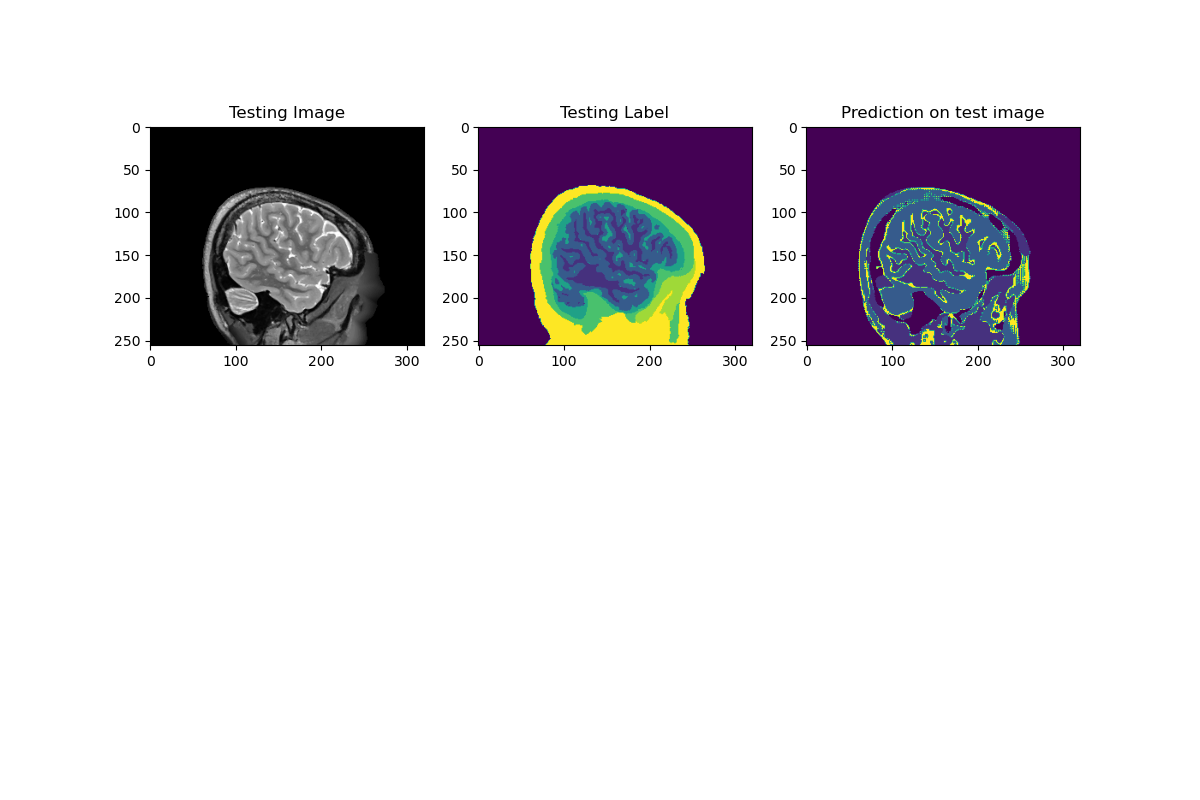

In [25]:
#Plot individual slices from test predictions for verification

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()